# AMV Historical Data

In [107]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [82]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [83]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [84]:
# 4. Chia train. test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [85]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [86]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [87]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [88]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [89]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 179ms/step - loss: 0.0497 - val_loss: 0.0223
Epoch 2/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0115 - val_loss: 0.0050
Epoch 3/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 4/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 5/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 6/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 9/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 10/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0033 - val_loss: 0.002

In [90]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 [==============================] - 1s 11ms/step


In [91]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 691.7218
MAPE trên tập test là: 2.676483243703842 %
MSLE trên tập test là: 0.0021607813


In [92]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6494845]
338
1 day input [0.77321943 0.7574124  0.7574124  0.76271186 0.7574124  0.74160537
 0.7574124  0.76271186 0.70994563 0.69939239 0.72049888 0.72575266
 0.72575266 0.69939239 0.74160537 0.70994563 0.70469185 0.65722509
 0.58865183 0.58865183 0.58335237 0.58865183 0.57809859 0.59390561
 0.58865183 0.5358856  0.48316506 0.45150532 0.44625154 0.50427155
 0.52007858 0.5358856  0.48316506 0.50427155 0.57284481 0.58865183
 0.60445886 0.57809859 0.56229156 0.59390561 0.67303212 0.7574124
 0.77851889 0.3834346  0.43807392 0.45625657 0.46539358 0.46233268
 0.44415003 0.44108913 0.39860204 0.39257161 0.40773905 0.39257161
 0.41075426 0.41075426 0.40467815 0.40467815 0.39860204 0.4259217
 0.42898259 0.42290648 0.43501302 0.45324135 0.47146969 0.44716524
 0.43807392 0.49874366 0.54429165 0.54429165 0.48357623 0.44716524
 0.45931747 0.52304811 0.47146969 0.49874366 0.5655352  0.57462652
 0.57462652 0.58677875 0.59587007 0.6049614  0.58677875 0.60802229
 0.63534195 0.63534195 0.62017452 0.

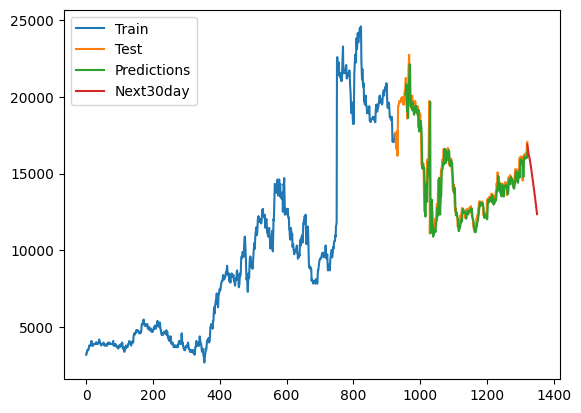

In [93]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DHT Historical Data

In [94]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [95]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [96]:
# 4. Chia train. test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [97]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [98]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [99]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [100]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 142ms/step - loss: 0.0465 - val_loss: 0.0038
Epoch 2/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0092 - val_loss: 0.0049
Epoch 3/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 4/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 5/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 9/100
14/14 [==============================] - 1s 80ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 10/100
14/14 [==============================] - 1s 85ms/step - loss: 0.0021 - val_loss: 0.001

In [102]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 [==============================] - 3s 24ms/step


In [103]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 497.08792
MAPE trên tập test là: 2.647334150969982 %
MSLE trên tập test là: 0.0013789056


In [104]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.11136608]
338
1 day input [0.29214628 0.30883293 0.3054956  0.29882094 0.29214628 0.28213429
 0.29882094 0.30048961 0.30215827 0.29548361 0.29548361 0.31550759
 0.33386791 0.32732814 0.32405576 0.36492806 0.33713529 0.31588229
 0.32405576 0.2929956  0.29953537 0.2946293  0.2946293  0.28318845
 0.27991607 0.27501499 0.25376199 0.25048961 0.25048961 0.25048961
 0.22596922 0.26356914 0.26193545 0.25048961 0.25048961 0.28154976
 0.28318845 0.28645584 0.28482214 0.28318845 0.28318845 0.28318845
 0.30607514 0.30607514 0.31098122 0.32242206 0.31915468 0.31588229
 0.31588229 0.29953537 0.29790168 0.28318845 0.29626799 0.30607514
 0.31588229 0.30607514 0.30280276 0.30770883 0.30770883 0.30770883
 0.31098122 0.30934253 0.31588229 0.32405576 0.3355016  0.31751599
 0.30934253 0.33713529 0.3976219  0.49244105 0.40579536 0.32732814
 0.31588229 0.31588229 0.30770883 0.31588229 0.31588229 0.31588229
 0.31098122 0.32405576 0.32078837 0.33059552 0.31751599 0.31588229
 0.31751599 0.32405576 0.32405576

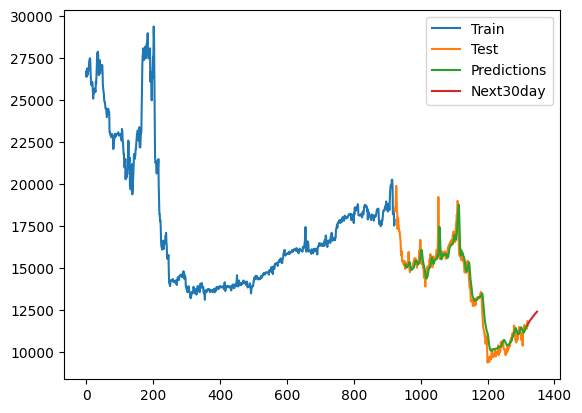

In [105]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DP3 Historical Data

In [121]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [122]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [123]:
# 4. Chia train. test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [124]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [125]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [126]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [127]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [128]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 8s 150ms/step - loss: 0.0654 - val_loss: 0.0075
Epoch 2/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0195 - val_loss: 0.0147
Epoch 3/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0127 - val_loss: 0.0050
Epoch 4/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0102 - val_loss: 0.0030
Epoch 5/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0095 - val_loss: 0.0027
Epoch 6/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 7/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 8/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 9/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 10/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0074 - val_loss: 0.002

In [129]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

10/10 [==============================] - 3s 29ms/step


In [130]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2690.974
MAPE trên tập test là: 2.48324666172266 %
MSLE trên tập test là: 0.0012798547


In [131]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3184307]
285
1 day input [0.06406406 0.06406406 0.03303303 0.06406406 0.11411411 0.05405405
 0.05405405 0.05405405 0.04404404 0.07407407 0.07407407 0.04404404
 0.06406406 0.09409409 0.09409409 0.07407407 0.07307307 0.07907908
 0.10910911 0.11411411 0.12412412 0.13413413 0.12612613 0.13413413
 0.13413413 0.13413413 0.15015015 0.12912913 0.13413413 0.12912913
 0.12412412 0.17317317 0.17117117 0.17217217 0.17317317 0.13413413
 0.13413413 0.16416416 0.17417417 0.16416416 0.17417417 0.17417417
 0.17417417 0.17417417 0.13413413 0.17417417 0.16416416 0.16416416
 0.13413413 0.13413413 0.11411411 0.16416416 0.16416416 0.16416416
 0.16416416 0.16416416 0.16516517 0.16516517 0.16416416 0.15415415
 0.21221221 0.15415415 0.15415415 0.15915916 0.16416416 0.19419419
 0.15215215 0.14414414 0.12912913 0.12412412 0.12412412 0.13413413
 0.14414414 0.14814815 0.11411411 0.10710711 0.09409409 0.08108108
 0.06906907 0.07207207 0.08408408 0.07407407 0.07407407 0.06906907
 0.06906907 0.06406406 0.06406406 

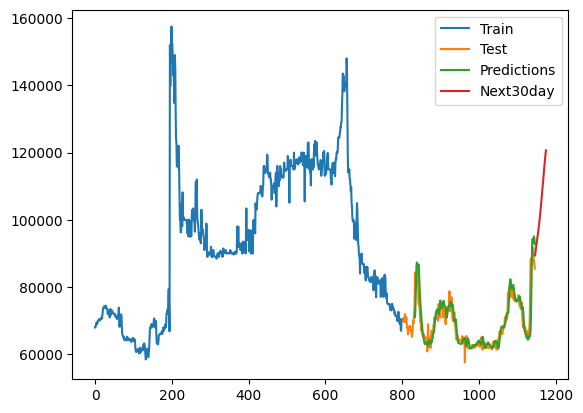

In [132]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()